# Problem Set 8

##### Due Friday December 2nd at 11:59pm

### Problem 1

<div>
<img src="problems/1.png" width="600">
</div>

First, we can rewrite our equation as:

$f(t+dt,x)-f(t-dt,x) = -\frac{vdt}{dx}(f(t,x+dx)-f(t,x-dx))$

Then, by substituting in our assumed aolution for f(x,t), we obtain:

$\xi^2-1=-2i\xi\frac{vdt}{dx}sin(kdx)$

Where $\xi$ is the amplitude of our function. Then, solving for $\xi$, we obtain:

$\xi=-i\frac{vdt}{dx}sin(kdx)\pm\sqrt{1-(\frac{vdt}{dx}sin(kdx))^2}$

From the leapfrog scheme, we now have an equation for the amplitude of our function. We can now apply the CFL condition and observe the resulting amplitude. Recall, the CFL condition states $vdt\leq dx$.

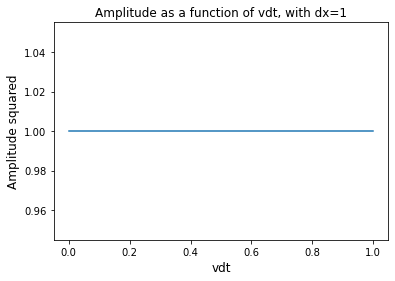

In [119]:
def xi(v, k, dx, dt):
    return -1j*(v*dt/dx)*np.sin(k*dx)+np.sqrt(1-(((v*dt)/dx)*np.sin(k*dx))**2)

v=np.linspace(0,1,101)
k=1
dx=1
dt=1

xi = xi_p(v,k,dx,dt)
xi_sqr = np.real(xp)**2+np.imag(xp)**2

plt.figure(figsize=(6,4))
plt.title('Amplitude as a function of vdt, with dx=1', fontsize=12)
plt.xlabel('vdt', fontsize=12)
plt.ylabel('Amplitude squared', fontsize=12)
plt.plot(v*dt, xi_sqr)

As we can see from the plot above, as long as the CFL condition is satisfied, $|\xi|^2=1$, therefore the leapfrog scheme preserves energy.

### Problem 2

##### part a)

<div>
<img src="problems/2a.png" width="600">
</div>

Note:

The potential we end up with for the point particle will not have $V(0,0)=1$ and $\rho(0,0)=1$, so we'll need to rescale it. In order to get $\rho(0,0)=1$, we need to rescale V: $V \rightarrow \frac{V}{V(0,0)-V(0,1)}$. This is because $\rho$ is defined as being the potential minus the average of neighbors, so for $\rho(0,0)$ to be 1, we need the difference between $V(0,0)$ and $V(0,1)$ to be 1, which is what our scaling factor does.

Now that $\rho(0,0)=1$, we can set $V(0,0)=1$ by simply rescaling V: $V \rightarrow V-(V(0,0)-1)$, and we can do this since we can add an arbitrary offset to a potential without affecting the physics of the situation.

p[0,0] =  0.999999999999984
V[0,0] =  1.0
V[1,0] =  0.0
V[2,0] =  -0.4999999999999756
V[5,0] =  -1.160964047443649


C:\Users\adesr\AppData\Local\Temp/ipykernel_19320/730712058.py:7: RuntimeWarning: divide by zero encountered in log
  return -np.log(r)


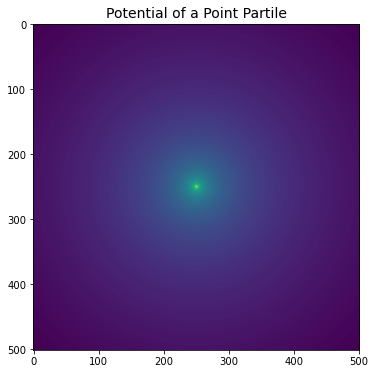

In [122]:
import numpy as np
import matplotlib.pyplot as plt

#function for calculating the 2d potential
def potential(x, y):
    r = np.sqrt(x**2+y**2)
    return -np.log(r)

#calculates the average of the 4 neighbors
#for each grid of our matrix
def average_neighbors(mat):
    out=0*mat
    out=out+np.roll(mat,1,0)
    out=out+np.roll(mat,-1,0)
    out=out+np.roll(mat,1,1)
    out=out+np.roll(mat,-1,1)
    return out/4

#potential of a point particle function
def point_potential(n, s=5, return_p=False):
    x, y = np.meshgrid(np.linspace(-s,s, n), np.linspace(-s,s, n))
    V = potential(x,y)

    center = 4*V[n//2,n//2+1]-V[n//2,n//2+2]-V[n//2-1,n//2+1]-V[n//2+1,n//2+1]
    center2 = 4*V[n//2-1,n//2]-V[n//2-2,n//2]-V[n//2-1,n//2+1]-V[n//2-1,n//2-1]
    center3 = 4*V[n//2,n//2-1]-V[n//2,n//2-2]-V[n//2-1,n//2-1]-V[n//2+1,n//2-1]
    center4 = 4*V[n//2+1,n//2]-V[n//2+1,n//2-1]-V[n//2+1,n//2+1]-V[n//2+2,n//2]
    c = np.average([center,center2,center3,center4])
    #all the centers give the same value, just calculated
    #all of them to make sure I didn't mess anything up

    V[n//2,n//2] = c #setting the center value
    scale = c-V[n//2,n//2+1] #scaling V so that p(0,0)=1
    V = V/scale
    cent = V[n//2,n//2]
    V = V-(cent-1) #offsetting V such that V(0,0)=1

    p = V-average_neighbors(V)

    if return_p is True:
        return V, p
    else:
        return V

#to note that in order to fix the singularity at 0, we need to
#evaluate our potential when r=0, so we need our x and y
#arrays to equal 0 at a point. This means that we need to choose
#an odd number for n such that the x, y meshgrid has a point at (0,0)
n=501
V, p = point_potential(n,return_p=True)

print('p[0,0] = ', p[n//2,n//2])
print('V[0,0] = ', V[n//2,n//2])
print('V[1,0] = ', V[n//2+1,n//2])
print('V[2,0] = ', V[n//2+2,n//2])
print('V[5,0] = ', V[n//2+5,n//2])

plt.figure(figsize=(8,6))
plt.title('Potential of a Point Partile', fontsize=14)
plt.imshow(V)

$V(1,0)$ is what we expect because we scaled such that $\rho(0,0)=1$, so therefore the difference between $V(0,0)$ and $V(1,0)$ would be 1, and since $V(0,0)$ is 1, then $V(1,0)$ is necessarily 0.

##### part b)

<div>
<img src="problems/2b.png" width="600">
</div>

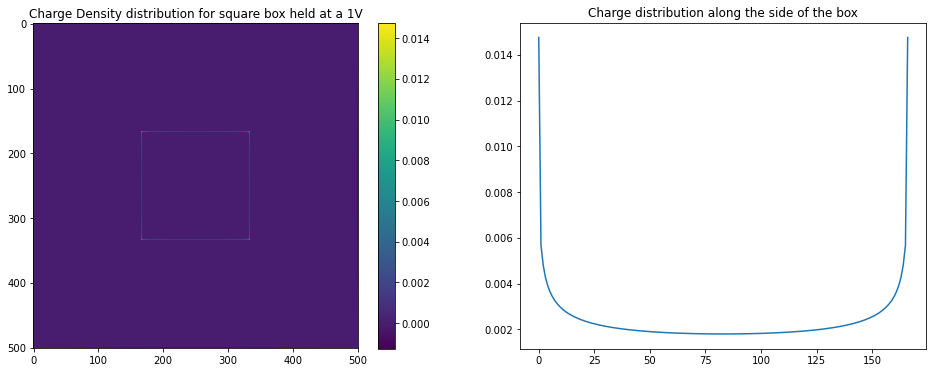

In [131]:
import numpy as np
from matplotlib import pyplot as plt
plt.ion()

#creating a class to make solving with conjugate gradient easier
class Grid:
    def __init__(self,mask,bc):
        self.mask = mask
        self.bc = bc
        
    def make_rhs(self):
        #for the Laplace equation, the rhs is
        #simply the average of neigbors of
        #our boundary condition
        rhs = average_neighbors(self.bc)
        #set masked areas equal to 0
        rhs[self.mask]=0 
        return rhs
    
    def __matmul__(self,x):
        x[self.mask] = 0
        ave = average_neighbors(x)
        ave[self.mask]=0
        return x-ave

#conjugate gradient solver
def conjgrad(A,b,min_resid=1e-16):
    #initializing x
    x=0*b
    #calculating the residual between the
    #true value and the value calculated
    #by our cj solver
    r=b-A@x
    p=r.copy()
    rtr=np.sum(r**2)
    #loop runs until acceptable residual
    #is achieved
    while rtr**2>min_resid**2:
        #conjugate gradient
        Ap=A@p
        pAp=np.sum(p*Ap)
        alpha=rtr/pAp
        x=x+alpha*p #update x
        r=r-alpha*Ap #update r
        rtr_new=np.sum(r**2)
        beta=rtr_new/rtr
        p=r+beta*p #update p
        rtr=rtr_new #update rTr
    return x

#recall we want n to be odd
n=501
bc = np.zeros([n,n])
mask = np.zeros([n,n],dtype='bool')

#masking the outline
mask[:,0] = True
mask[:,-1] = True
mask[0,:] = True
mask[-1,:] = True

#creating our square box held
#at a potential of 1
bc[n//3:2*n//3,n//3:2*n//3] = 1.0
#masking over that square box
mask[n//3:2*n//3,n//3:2*n//3] = True

A = Grid(mask,bc)
b = A.make_rhs()
V = conjgrad(A,b,min_resid=1e-18)
#setting the calculated potential in
#the square box to the potential from
#our initial boundary conditions
V[A.mask] = A.bc[A.mask]

rho = V-average_neighbors(V)

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.title('Charge Density distribution for square box held at a 1V')
plt.imshow(rho)
plt.colorbar()
plt.subplot(1,2,2)
plt.title('Charge distribution along the side of the box')
plt.plot(rho[n//3,n//3:2*n//3])
plt.show()

##### part c)

<div>
<img src="problems/2c.png" width="600">
</div>

C:\Users\adesr\AppData\Local\Temp/ipykernel_19320/730712058.py:7: RuntimeWarning: divide by zero encountered in log
  return -np.log(r)


Inside the box, the potential is held at 0.974±0.066V


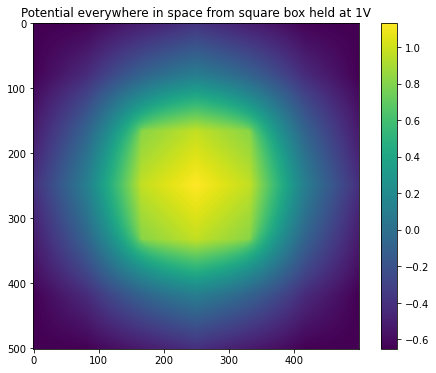

In [125]:
rhoft = np.fft.rfft2(rho)
vpft = np.fft.rfft2(point_potential(n))

pot = np.fft.irfft2(rhoft*vpft)
pot = np.fft.fftshift(pot)

plt.figure(figsize=(8,6))
plt.title('Potential everywhere in space from square box held at 1V')
plt.imshow(pot)
plt.colorbar()

meanbox = np.mean(pot[n//3:2*n//3,n//3:2*n//3])
stdbox = np.std(pot[n//3:2*n//3,n//3:2*n//3])

print('Inside the box, the potential is held at {}±{}V'.format(round(meanbox, 3), round(stdbox, 3)))

The potential on the inside of the square box is very close to constant, being held at 0.974±0.066V. However, there is a clear evolution of the potential throughout the box, its not like it is overall constant throughout with uniform noise. This can be seen if we simply plot the square box itself, as seen below.

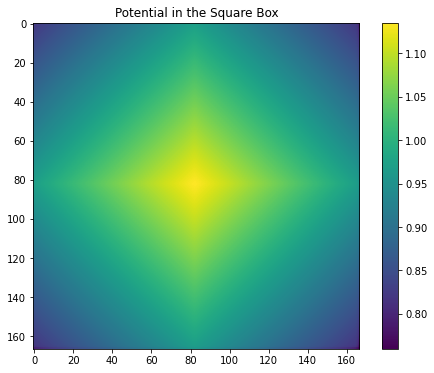

In [130]:
plt.figure(figsize=(8,6))
plt.title('Potential in the Square Box')
plt.imshow(pot[n//3:2*n//3,n//3:2*n//3])
plt.colorbar()

Text(0, 0.5, 'V')

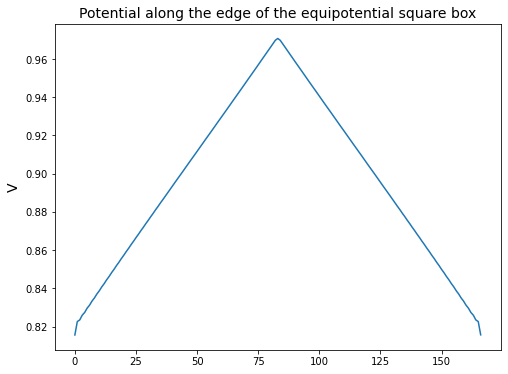

In [129]:
plt.figure(figsize=(8,6))
plt.title('Potential along the edge of the equipotential square box', fontsize=14)
plt.plot(pot[n//3,n//3-1:2*n//3-1])
plt.ylabel('V', fontsize=14)

This is not what I'd expect the potential just on the edge of a square box held at 1V to be. I would have expected a constant potential that drops off on the edges as the plot reaches the edges of the square box, as our equipotential lines should be perpendicular to the field emitting from the square box. However, as demonstrated above, the potential in our square box created by our convolution is not constant throughout with uniform noise, but rather rises near the middle of each side to form a type of star shape. Knowing this, then this IS actually what I'd expect the potential on the edge of the box to resemble, as now our field lines aren't eminatting perpendicular to the edge of the box, but rather perpendicular to this star shape.